In [1]:
from matplotlib.pyplot import style

style.use("seaborn-notebook")

# Accessing IOOS CO-OPS.NOS data via ERDDAP

<https://tidesandcurrents.noaa.gov/about.html>

In [2]:
from erddapy import ERDDAP

server = "https://opendap.co-ops.nos.noaa.gov/erddap"
e = ERDDAP(server=server, protocol="tabledap")

In [3]:
dataset_id = "IOOS_Hourly_Height_Verified_Water_Level"

e.dataset_id = dataset_id

The `dataset_id` can be found by searching the server with the `get_search_url` or with the browser.

We can check what is in the dataset with ERDDAP's `info` URL.

In [4]:
import pandas as pd

info_url = e.get_info_url(dataset_id=dataset_id, response="csv")

info = pd.read_csv(info_url)
info.head()

,Row Type,Variable Name,Attribute Name,Data Type,Value
0,attribute,NC_GLOBAL,cdm_data_type,String,TimeSeries
1,attribute,NC_GLOBAL,cdm_timeseries_variables,String,"STATION_ID,BEGIN_DATE,END_DATE"
2,attribute,NC_GLOBAL,Conventions,String,"COARDS, CF-1.6, ACDD-1.3"
3,attribute,NC_GLOBAL,featureType,String,TimeSeries
4,attribute,NC_GLOBAL,geospatial_lat_units,String,degrees_north


The variables are:

In [5]:
set(info["Variable Name"])

{'BEGIN_DATE',
 'DATUM',
 'END_DATE',
 'I',
 'L',
 'NC_GLOBAL',
 'SIGMA',
 'STATION_ID',
 'WL_VALUE',
 'latitude',
 'longitude',
 'time'}

This server have some `REQUIRED` variables for each request to get a valid URL,

In [6]:
info.loc[info["Value"].astype(str).str.startswith("REQUIRED")]

,Row Type,Variable Name,Attribute Name,Data Type,Value
19,attribute,STATION_ID,long_name,String,REQUIRED 7-character Station ID surrounded in ...
36,attribute,DATUM,long_name,String,REQUIRED 3- to 4-character Datum surrounded in...
41,attribute,BEGIN_DATE,long_name,String,REQUIRED 8- to 14-character Begin Date (yyyymm...
45,attribute,END_DATE,long_name,String,REQUIRED 8- to 14-character End Date (yyyymmdd...


and the time has its own special format.

In [7]:
pd.set_option("max_colwidth", 100)

info.loc[info["Variable Name"] == "END_DATE"]["Value"].iloc[-1]

'REQUIRED 8- to 14-character End Date (yyyymmdd hh:mi) surrounded in double quotes'

[With most ERDDAP servers](https://ioos.github.io/erddapy/) we can pass the time constraint as any valid time string or a python object, this dataset uses `yyyymmdd` for some reason :-/

Also, because this server has some **required** variables, and the time constraints does not work here, we must pass the actual variable values as constraints.

In [8]:
e.constraints = {
    "BEGIN_DATE=": "20140801",
    "END_DATE=": "20140901",
    "DATUM=": "MLLW",
    "STATION_ID=": "8570283",
}

url = e.get_download_url()

print(url)

https://opendap.co-ops.nos.noaa.gov/erddap/tabledap/IOOS_Hourly_Height_Verified_Water_Level.html?&BEGIN_DATE="20140801"&END_DATE="20140901"&DATUM="MLLW"&STATION_ID="8570283"


We can request the data from that URL as netCDF, CSV, JSON, etc. B/c it is a time-series let's request a `csv` and put it in a pandas `DataFrame` via the `to_pandas` method.

In [9]:
df = e.to_pandas(index_col="time (UTC)", parse_dates=True,).dropna()

# Make it a naive time zone for plotting.
df.index = df.index.tz_localize(None)

df.head()

,STATION_ID,latitude (degrees_north),longitude (degrees_east),DATUM,BEGIN_DATE,END_DATE,WL_VALUE (meters),SIGMA (meters),I,L
time (UTC),,,,,,,,,,
2014-08-01 00:00:00,8570283,38.3283,-75.0917,MLLW,20140801,20140901,0.397,0.013,0,0
2014-08-01 01:00:00,8570283,38.3283,-75.0917,MLLW,20140801,20140901,0.540,0.012,0,0
2014-08-01 02:00:00,8570283,38.3283,-75.0917,MLLW,20140801,20140901,0.643,0.016,0,0
2014-08-01 03:00:00,8570283,38.3283,-75.0917,MLLW,20140801,20140901,0.722,0.014,0,0
2014-08-01 04:00:00,8570283,38.3283,-75.0917,MLLW,20140801,20140901,0.731,0.016,0,0


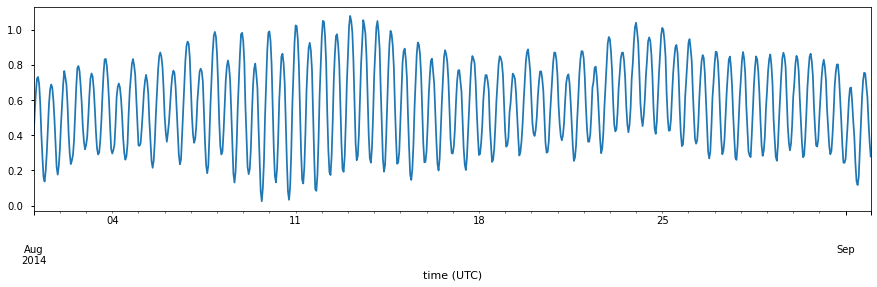

In [10]:
%matplotlib inline


df["WL_VALUE (meters)"].plot(figsize=(15, 3.75));

Exercise:

- Change the constraints below and create a similar plot. Start with the dates.
- Try to find another stations (STATION_ID) by browsing the [dataset online](https://opendap.co-ops.nos.noaa.gov/erddap). Was that easy?

```python
e.constraints = {
    "BEGIN_DATE=": "20140801",
    "END_DATE=": "20140901",
    "DATUM=": "MLLW",
    "STATION_ID=": "8570283",
}

url = e.get_download_url()

```